In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

2023-04-19 14:25:59.681124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 14:25:59.840509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 14:25:59.841534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 14:26:00.780014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [45]:
from io import BytesIO

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.transforms import IdentityTransform
import keras

In [4]:
%matplotlib inline

In [5]:
attribute_path = "/home/ali/projects/photo_collection/celebface-archive/list_attr_celeba.csv"
partition_path = "/home/ali/projects/photo_collection/celebface-archive/list_eval_partition.csv"
images_path = "/home/ali/projects/photo_collection/celebface-archive/img_align_celeba/img_align_celeba/"
batch_size = 128
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"
image_size = (224, 224)

In [6]:
df_attributes = pd.read_csv(attribute_path)

In [7]:
df_attributes


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [8]:
df_attributes.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [9]:
df_partition = pd.read_csv(partition_path)

In [10]:
df = pd.merge(df_attributes, df_partition, on="image_id")
df = df.replace(-1,0)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [11]:
# Discard blurry images
df = df[df["Blurry"] ==0].copy()

In [12]:
selected_attributes = ["5_o_Clock_Shadow", "Bald", "Black_Hair", "Blond_Hair", "Brown_Hair",
                       "Eyeglasses", "Goatee", "Gray_Hair", "Male", "Mustache", "Smiling", "No_Beard",
                       "Wearing_Earrings", "Wearing_Hat"]

In [13]:
column_list = ["image_id"]
column_list.extend(selected_attributes)

In [14]:
df_attributes_selected = df[df.columns.intersection(column_list)].copy()

In [15]:
df_attributes_selected

,image_id,5_o_Clock_Shadow,Bald,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,Male,Mustache,No_Beard,Smiling,Wearing_Earrings,Wearing_Hat
0,000001.jpg,0,0,0,0,1,0,0,0,0,0,1,1,1,0
1,000002.jpg,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,000004.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,000005.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,000006.jpg,0,0,0,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,0,0,0,1,0,0,0,0,0,0,1,0,0,0
202595,202596.jpg,0,0,0,1,0,0,0,0,1,0,1,1,0,0
202596,202597.jpg,0,0,1,0,0,1,0,0,1,0,1,1,0,0
202597,202598.jpg,0,0,1,0,0,0,0,0,0,0,1,1,1,0


### Cleaning the data set

We need to clean the dataset to remove the following faulty instances:

- Instances where the person is not wearing a hat and is not bald, yet no hair colour is assigned.
- Instances where more than one hair colour is assigned to the person.

In [16]:
df_attributes_selected = df_attributes_selected.loc[~(df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] > 1)].copy()

In [17]:
df_attributes_selected = df_attributes_selected.loc[~((df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] == 0) & (df_attributes_selected["Wearing_Hat"] + df_attributes_selected["Bald"] == 0))].copy()

In [18]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    return image

In [19]:
def load_and_preprocess_image(path, *args):
    image = tf.io.read_file(path)
    return preprocess_image(image), *args

In [20]:
def build_dataset_from_df(input_df, attr_list):
    b_list = [input_df[attr] for attr in attr_list]
    b_list.insert(0, [images_path + image_id for image_id in input_df["image_id"]])
    a_tuple = tuple(b_list)
    dataset = tf.data.Dataset.from_tensor_slices(a_tuple)
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    #TODO check the effect of dataset.repeat()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [22]:
train_df = df_attributes_selected.loc[df["partition"] == 0]
#TODO remove these to use all instances when you made sure it is working
train_df = train_df.sample(n=500)
train_ds = build_dataset_from_df(train_df, selected_attributes)

val_df = df_attributes_selected.loc[df["partition"] == 1]
val_df = val_df.sample(n=100)
val_ds = build_dataset_from_df(val_df, selected_attributes)

In [23]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-19 14:26:34.843644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [500]
	 [[{{node Placeholder/_11}}]]
2023-04-19 14:26:34.844808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int64 and shape [500]
	 [[{{node Placeholder/_13}}]]


[(array([[[[4.20000000e+01, 5.50000000e+01, 4.60000000e+01],
           [4.40758934e+01, 5.70758934e+01, 4.80758934e+01],
           [4.50000000e+01, 5.75133934e+01, 4.80267868e+01],
           ...,
           [1.75053589e+02, 1.65513397e+02, 1.62486603e+02],
           [1.79772400e+02, 1.68156311e+02, 1.63540222e+02],
           [1.86000000e+02, 1.73000000e+02, 1.67000000e+02]],
  
          [[4.10401802e+01, 5.11607132e+01, 4.31205368e+01],
           [4.51085587e+01, 5.52290955e+01, 4.65247498e+01],
           [4.78537521e+01, 5.79547386e+01, 4.89351883e+01],
           ...,
           [2.01817459e+02, 1.89839142e+02, 1.83932877e+02],
           [1.83845840e+02, 1.68390472e+02, 1.61190582e+02],
           [6.98616028e+01, 5.30223160e+01, 4.51026764e+01]],
  
          [[5.49955330e+01, 5.84642868e+01, 5.13973198e+01],
           [5.20454216e+01, 5.55141716e+01, 4.71096153e+01],
           [4.89812241e+01, 5.24499741e+01, 4.34499741e+01],
           ...,
           [2.24209671e+02, 2

In [24]:
next_batch = next(iter(train_ds))

2023-04-19 14:26:36.367529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [500]
	 [[{{node Placeholder/_9}}]]
2023-04-19 14:26:36.368548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [500]
	 [[{{node Placeholder/_9}}]]


In [25]:
print (f"Image shape: {next_batch[0][1].numpy().shape}")
for i in range(len(selected_attributes)):
    print (f"{selected_attributes[i]} shape: {next_batch[i+1].shape}")

Image shape: (224, 224, 3)
5_o_Clock_Shadow shape: (128,)
Bald shape: (128,)
Black_Hair shape: (128,)
Blond_Hair shape: (128,)
Brown_Hair shape: (128,)
Eyeglasses shape: (128,)
Goatee shape: (128,)
Gray_Hair shape: (128,)
Male shape: (128,)
Mustache shape: (128,)
Smiling shape: (128,)
No_Beard shape: (128,)
Wearing_Earrings shape: (128,)
Wearing_Hat shape: (128,)


In [26]:
def text_to_rgba(some_str, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, some_str, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba_out = plt.imread(buf)
    return rgba_out

<Figure size 640x480 with 0 Axes>

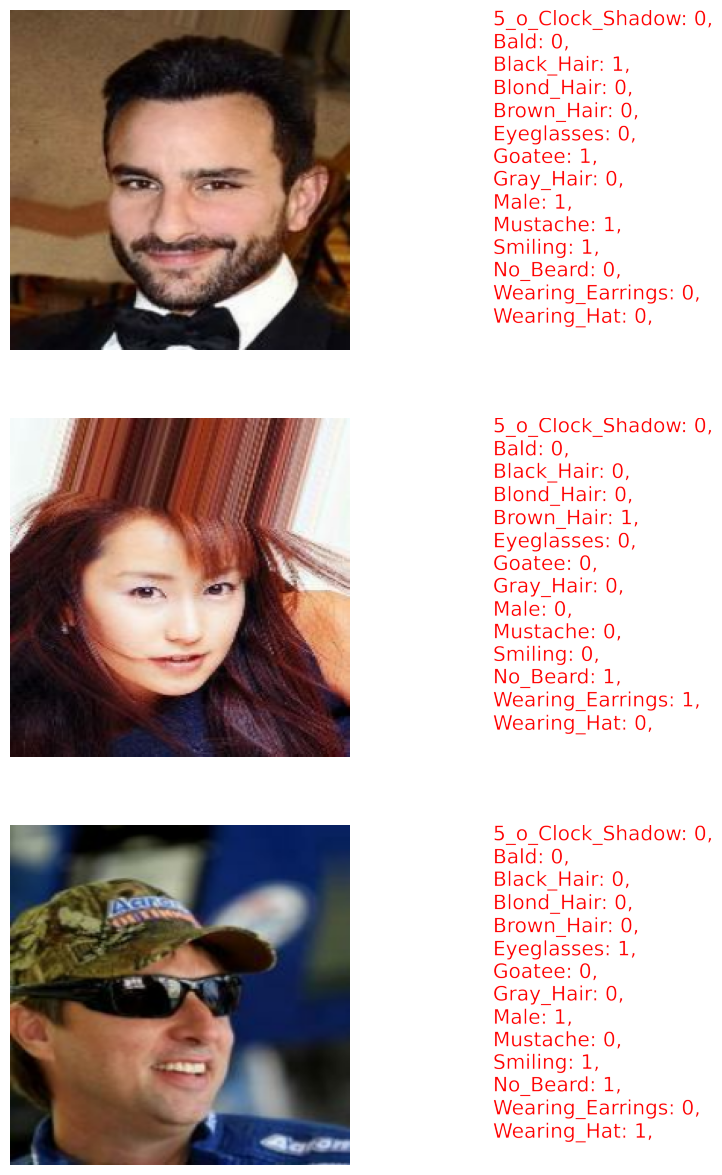

In [27]:
next_batch = next(iter(train_ds))
plt.tight_layout()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axs[i, 0].imshow(next_batch[0][i].numpy().astype("uint8"))
    axs[i, 0].axis("off")
    s = ""
    for j in range (len(selected_attributes)):
        s = s + f"{selected_attributes[j]}: {next_batch[j+1][i].numpy()},\n"
    rgba = text_to_rgba(s, color="red", fontsize=50, dpi=200)
    axs[i, 1].imshow(rgba)
    axs[i, 1].axis("off")

In [28]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

In [29]:
def apply_preprocessing_model(images, *args):
    return (preprocessing_model(images), (args))

In [30]:
def apply_normalization_layer(images, *args):
    return (normalization_layer(images), (args))

In [31]:
train_ds = train_ds.map(apply_preprocessing_model)
val_ds = val_ds.map(apply_normalization_layer)

In [32]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-19 14:26:48.106233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [500]
	 [[{{node Placeholder/_0}}]]
2023-04-19 14:26:48.106803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64 and shape [500]
	 [[{{node Placeholder/_12}}]]


[(array([[[[0.30980393, 0.2392157 , 0.15294118],
           [0.30709037, 0.23650213, 0.1502276 ],
           [0.30779064, 0.23720239, 0.15092787],
           ...,
           [0.32697815, 0.22501737, 0.11913501],
           [0.31463602, 0.21509126, 0.10800087],
           [0.3254902 , 0.23137257, 0.12156864]],
  
          [[0.30603993, 0.2354517 , 0.14917718],
           [0.30332634, 0.23273812, 0.1464636 ],
           [0.30585822, 0.23526998, 0.14899546],
           ...,
           [0.32901144, 0.22705065, 0.12116829],
           [0.3233235 , 0.22377874, 0.11668837],
           [0.33678222, 0.24266458, 0.13286065]],
  
          [[0.3022234 , 0.23163517, 0.14536065],
           [0.3020417 , 0.23145345, 0.14517893],
           [0.3057773 , 0.23518908, 0.14891458],
           ...,
           [0.33661056, 0.23464978, 0.12876742],
           [0.3371959 , 0.23765114, 0.13056076],
           [0.34823182, 0.25411418, 0.14431024]],
  
          ...,
  
          [[0.4977767 , 0.28993353, 0.12

In [40]:
do_fine_tuning = False
image_input = tf.keras.Input(shape=image_size + (3,))
en_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(image_input)
en_model = tf.keras.layers.Dropout(rate=0.2)(en_model)
en_model = tf.keras.layers.Dense(128, activation="relu")(en_model)
output_layers = []
for attr in selected_attributes:
    output_layers.append(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=f'{attr}')(en_model))

model = tf.keras.Model( inputs = image_input, outputs = output_layers)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_1 (KerasLayer)     (None, 1280)         5919312     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 1280)         0           ['keras_layer_1[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 128)          163968      ['dropout_1[0][0]']        

In [55]:
model.compile(
    loss = {f"{attr}": tf.keras.losses.BinaryCrossentropy() for attr in selected_attributes},
    metrics = {f"{attr}": [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] for attr in selected_attributes},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [56]:
# Train the model if not previously trained
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
3/3 [==============================] - 17s 3s/step - loss: 4.4750 - 5_o_Clock_Shadow_loss: 0.3651 - Bald_loss: 0.1345 - Black_Hair_loss: 0.5160 - Blond_Hair_loss: 0.3425 - Brown_Hair_loss: 0.5608 - Eyeglasses_loss: 0.1976 - Goatee_loss: 0.2004 - Gray_Hair_loss: 0.2158 - Male_loss: 0.2515 - Mustache_loss: 0.1427 - Smiling_loss: 0.6469 - No_Beard_loss: 0.3100 - Wearing_Earrings_loss: 0.4551 - Wearing_Hat_loss: 0.1333 - 5_o_Clock_Shadow_precision_14: 0.0000e+00 - 5_o_Clock_Shadow_recall: 0.0000e+00 - Bald_precision_15: 0.0000e+00 - Bald_recall_1: 0.0000e+00 - Black_Hair_precision_16: 0.6857 - Black_Hair_recall_2: 0.5217 - Blond_Hair_precision_17: 0.8125 - Blond_Hair_recall_3: 0.3333 - Brown_Hair_precision_18: 0.5873 - Brown_Hair_recall_4: 0.3109 - Eyeglasses_precision_19: 0.0000e+00 - Eyeglasses_recall_5: 0.0000e+00 - Goatee_precision_20: 0.0000e+00 - Goatee_recall_6: 0.0000e+00 - Gray_Hair_precision_21: 0.0000e+00 - Gray_Hair_recall_7: 0.0000e+00 - Male_precision_22: 0.9825 - M

In [29]:
# Load trained and saved model
trained_model = tf.keras.models.load_model('face_eff_net_all_samples')
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [92]:
# Make predictions using newly trained model

# x, y = next(iter(val_ds))
# image = x[0, :, :, :]
# plt.imshow(image)
# plt.axis('off')
# plt.show()
#
# prediction_scores = model.predict(np.expand_dims(image, axis=0))
# for i, label in enumerate(["Male", "Smiling", "Young"]):
#     pred = prediction_scores[i][0][0]
#     print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

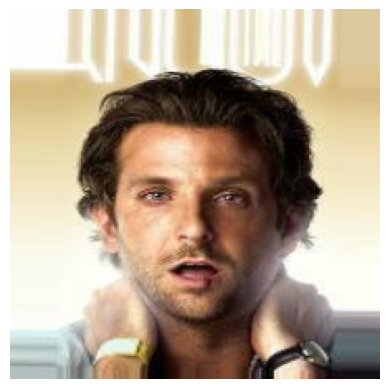

1/1 [==============================] - 0s 61ms/step
5_o_Clock_Shadow: actual 1, predicted 1 (0.8911)
Bald: actual 0, predicted 0 (0.0003)
Bangs: actual 0, predicted 0 (0.0011)
Black_Hair: actual 1, predicted 1 (0.6515)
Blond_Hair: actual 0, predicted 0 (0.0004)
Brown_Hair: actual 0, predicted 0 (0.0634)
Eyeglasses: actual 0, predicted 0 (0.0001)
Goatee: actual 0, predicted 0 (0.3710)
Gray_Hair: actual 0, predicted 0 (0.0025)
Male: actual 1, predicted 1 (0.9981)
Mustache: actual 0, predicted 0 (0.1416)
No_Beard: actual 0, predicted 0 (0.0190)
Sideburns: actual 0, predicted 1 (0.6997)
Smiling: actual 0, predicted 0 (0.0115)
Straight_Hair: actual 0, predicted 0 (0.1267)
Wavy_Hair: actual 1, predicted 0 (0.1617)
Wearing_Earrings: actual 0, predicted 0 (0.0018)
Wearing_Hat: actual 0, predicted 0 (0.0007)
Wearing_Lipstick: actual 0, predicted 0 (0.0014)
Wearing_Necklace: actual 0, predicted 0 (0.0181)
Wearing_Necktie: actual 0, predicted 0 (0.0034)


In [204]:
# Make predictions using loaded model
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = trained_model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(selected_attributes):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")